## Load and set up images

In [1]:
%matplotlib widget
import numpy as np
import scipy
import xarray as xr
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm.notebook import tqdm

In [2]:
nc_fn = "E:/research_data/2022_harmonic_gravity_waves/preprocessed_images/bore_ex.nc"
ds = xr.open_dataset(nc_fn)

In [3]:
times = ds.time

In [4]:
ds.rad255.shape

(2304, 4064, 16)

In [5]:
img_array = ds.sel(time=times[0]).rad255.values[582:2304, 2650:3600]

In [6]:
img_array_thresh = np.where(img_array == 255, 0., img_array)

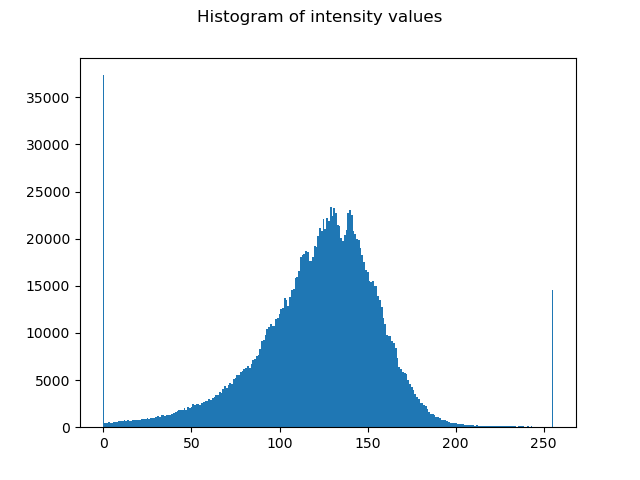

In [7]:
F, ax = plt.subplots()
F.suptitle("Histogram of intensity values")
ax.hist(img_array.ravel(), bins=256, range=(-0.5, 255.5));

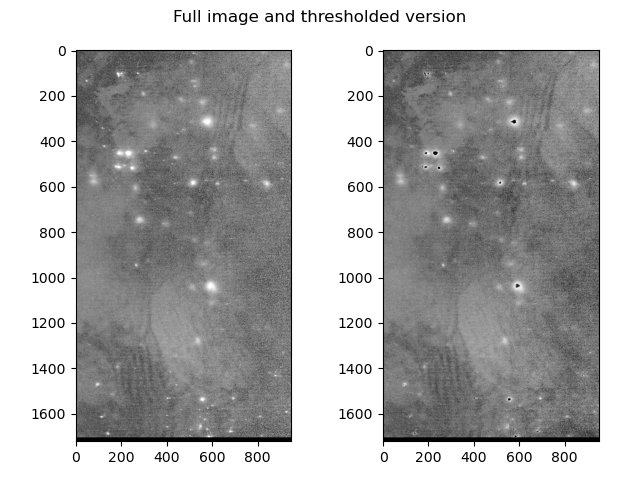

In [8]:
F, ax = plt.subplots(1, 2)
F.suptitle("Full image and thresholded version")
ax[0].imshow(img_array, cmap='gray', clim=(0, 255))
ax[1].imshow(img_array_thresh, cmap='gray', clim=(0, 255))
F.tight_layout()

In [9]:
xystart = (613, 181)
xyend = (727, 344)
img_crop = img_array[slice(xystart[1], xyend[1]), xystart[0]:xyend[0]]
img_crop_thresh = img_array_thresh[xystart[1]:xyend[1], xystart[0]:xyend[0]]

In [10]:
F, ax = plt.subplots(1, 2)
F.suptitle("Zooms on example region")
ax[0].imshow(img_crop, cmap='gray', clim=(0, 255))
ax[1].imshow(img_crop_thresh, cmap='gray', clim=(0, 255))

## Set up autocorrelation functions

In [11]:
def auto_correlate(img, x, y, width, height, xrange=None, yrange=None):
    if xrange==None:
        xrange = width//2
    if yrange==None:
        yrange = height//2
        
    img_crop = img[y:y+height, x:x+width]
    img_crop = (img_crop - img_crop.mean()) / img_crop.std()
    
    normalizer = np.sum(img_crop * img_crop)
    
    full_xrange = range(0, 2*xrange)
    full_yrange = range(0, 2*yrange)
    
    corr_img = np.zeros((len(full_yrange), len(full_xrange)))
    
    for xt in full_xrange:
        for yt in full_yrange:
            x_ref = x + (xt - xrange)
            y_ref = y + (yt - yrange)
            img_comp = img[y_ref:y_ref+height, x_ref:x_ref+width]
            img_comp = (img_comp - img_comp.mean()) / img_comp.std()
            corr_img[yt, xt] = np.sum(img_comp * img_crop) / normalizer
    
    corr_img[yrange, xrange] = np.NaN
            
    return corr_img

In [86]:
def local_auto_corr(img, width, height=None):
    if height is None:
        height = width
    
    xnum = (img.shape[1] // width) - 1
    ynum = (img.shape[0] // height) - 1
    
    x_vals = [width // 2 + i * width for i in range(xnum)]
    y_vals = [height // 2 + i * height for i in range(ynum)]
    
    corr_im = np.full(img.shape, np.NaN)
    
    for x in tqdm(x_vals):
        for y in y_vals:
            corr_im_temp = auto_correlate(img, x, y, width, height)
            corr_im[y:y+corr_im_temp.shape[0], x:x+corr_im_temp.shape[1]] = corr_im_temp
            
    return corr_im

In [85]:
def local_auto_corr_patches(img, width, height=None):
    if height is None:
        height = width
    
    xnum = (img.shape[1] // width) - 1
    ynum = (img.shape[0] // height) - 1
    
    x_vals = [width // 2 + i * width for i in range(xnum)]
    y_vals = [height // 2 + i * height for i in range(ynum)]
    
    corr_ims = None
    
    patch_id = 0
    
    for x in tqdm(x_vals):
        for y in y_vals:
            corr_im_temp = xr.Dataset(
                data_vars = dict(
                    patch = (["row", "col", "patch_id"], np.expand_dims(auto_correlate(img, x, y, width, height), axis=-1)),
                ),
                coords = dict(
                    loc_id = (["loc", "patch_id"], np.expand_dims((x, y), axis=-1)),
                    patch_id = (["patch_id"], [patch_id])
                )
            )
            if corr_ims is None:
                corr_ims = corr_im_temp
            else:
                corr_ims = xr.concat([corr_ims, corr_im_temp], dim="patch_id")
            patch_id += 1
                
    return corr_ims

In [76]:
np.expand_dims((3, 5), axis=-1).shape

(2, 1)

## Run autocorrelation on test region

In [13]:
corr_img = auto_correlate(img_array, xystart[0], xystart[1], xyend[0] - xystart[0], xyend[1] - xystart[1])
corr_img_thresh = auto_correlate(img_array_thresh, xystart[0], xystart[1], xyend[0] - xystart[0], xyend[1] - xystart[1])

In [44]:
vmin = min([np.nanmin(corr_img), np.nanmin(corr_img_thresh)])
vmax = max([np.nanmax(corr_img), np.nanmax(corr_img_thresh)])

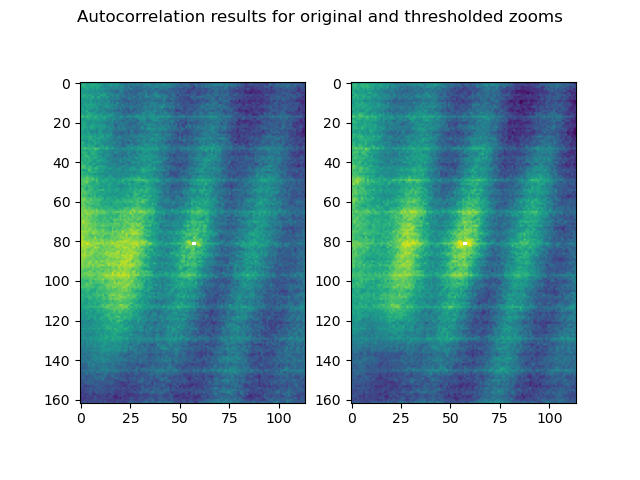

In [15]:
F, ax = plt.subplots(1, 2)
F.suptitle("Autocorrelation results for original and thresholded zooms")
ax[0].imshow(corr_img, cmap='viridis', clim=(vmin, vmax))
ax[1].imshow(corr_img_thresh, cmap='viridis', clim=(vmin, vmax))

In [23]:
np.std((img_crop - img_crop.mean()) / img_crop.std())

1.0

## Autocorrelate entire image

In [84]:
square_size = 50

In [65]:
corr_im = local_auto_corr(img_array, square_size, square_size)
corr_im_filled = np.where(np.isnan(corr_im), 0.0, corr_im)
corr_im_2 = local_auto_corr(corr_im_filled, square_size, square_size)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [87]:
corr_im_patches = local_auto_corr_patches(img_array, square_size)

  0%|          | 0/18 [00:00<?, ?it/s]

In [158]:
def total_var(patch):
    dif_1 = np.abs(patch[:, :-1] - patch[:, 1:])
    np.where(np.isnan(dif_1), 0, dif_1)
    dif_2 = np.abs(patch[:-1, :] - patch[1:, :])
    np.where(np.isnan(dif_2), 0, dif_2)
    
    return np.sum(dif_1) + np.sum(dif_2)

In [162]:
corr_im_patches = corr_im_patches.assign(tv=xr.concat([total_var(corr_im_patches.patch[:, :, i]) for i in tqdm(range(corr_im_patches.patch_id.shape[0]))], dim="patch_id"))

  0%|          | 0/594 [00:00<?, ?it/s]

In [188]:
corr_im_patches

<xarray.Dataset>
Dimensions:   (row: 50, col: 50, patch_id: 594, loc: 2)
Coordinates:
    loc_id    (loc, patch_id) int32 25 25 25 25 25 ... 1425 1475 1525 1575 1625
  * patch_id  (patch_id) int32 0 1 2 3 4 5 6 7 ... 587 588 589 590 591 592 593
Dimensions without coordinates: row, col, loc
Data variables:
    patch     (row, col, patch_id) float64 0.01108 0.03981 ... 0.01319 -0.03181
    tv        (patch_id) float64 108.8 93.3 81.23 105.8 ... 111.5 101.3 102.1
    max_val   (patch_id) float64 0.121 0.1556 0.3851 ... 0.07321 0.09749 0.06636

In [187]:
corr_im_patches = corr_im_patches.assign(max_val=xr.concat([corr_im_patches.patch[:, :, i].max() for i in corr_im_patches.patch_id], dim="patch_id"))

In [189]:
sorted_patches = corr_im_patches.sortby('max_val', ascending=False)

In [191]:
sorted_patches

<xarray.Dataset>
Dimensions:   (row: 50, col: 50, patch_id: 594, loc: 2)
Coordinates:
    loc_id    (loc, patch_id) int32 175 225 575 175 575 ... 925 775 675 725 675
  * patch_id  (patch_id) int32 107 140 383 108 368 335 ... 480 576 277 542 409
Dimensions without coordinates: row, col, loc
Data variables:
    patch     (row, col, patch_id) float64 0.02989 0.04246 ... 0.002021
    tv        (patch_id) float64 106.8 100.0 101.7 118.0 ... 108.4 109.7 106.6
    max_val   (patch_id) float64 0.8832 0.8732 0.8545 ... 0.06019 0.05765

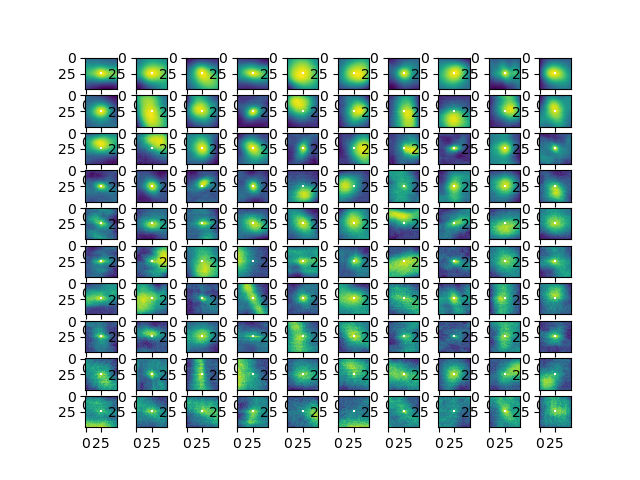

In [190]:
F, axes = plt.subplots(10, 10)
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(sorted_patches.patch[:, :, i].values)

In [66]:
F, ax = plt.subplots(1, 1)
ax.imshow(img_array, cmap='gray', clim=(0, 255))
ax.set_title('Original image')

Text(0.5, 1.0, 'Original image')

Text(0.5, 1.0, 'Autocorrelation')

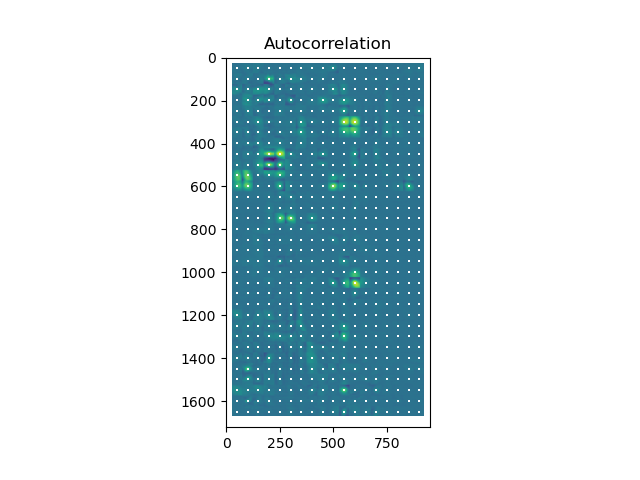

In [68]:
F, ax = plt.subplots(1, 1)
ax.imshow(corr_im)
ax.set_title('Autocorrelation')

NameError: name 'corr_im_2' is not defined

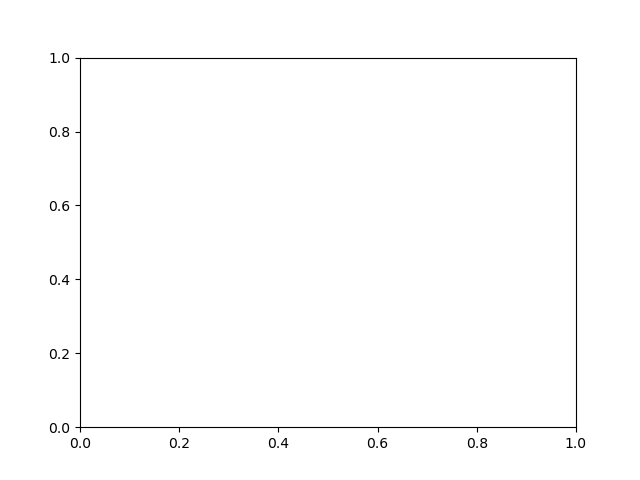

In [177]:
F, ax = plt.subplots(1, 1)
ax.imshow(corr_im_2)
ax.set_title('Second autocorrelation')

In [26]:
start = timer()
corr_im_thresh = local_auto_corr(img_array_thresh, square_size, square_size)
print(f'First autocorrelation took {timer() - start} seconds for a {img_array_thresh.shape} image')
corr_im_thresh_filled = np.where(np.isnan(corr_im_thresh), 0.0, corr_im_thresh)
start = timer()
corr_im_thresh_2 = local_auto_corr(corr_im_thresh_filled, square_size, square_size)
print(f'Second autocorrelation took {timer() - start} seconds for a {corr_im_thresh.shape} image')

  0%|          | 0/18 [00:00<?, ?it/s]

First autocorrelation took 33.915871599980164 seconds for a (1722, 950) image


  0%|          | 0/18 [00:00<?, ?it/s]

Second autocorrelation took 34.25178459996823 seconds for a (1722, 950) image


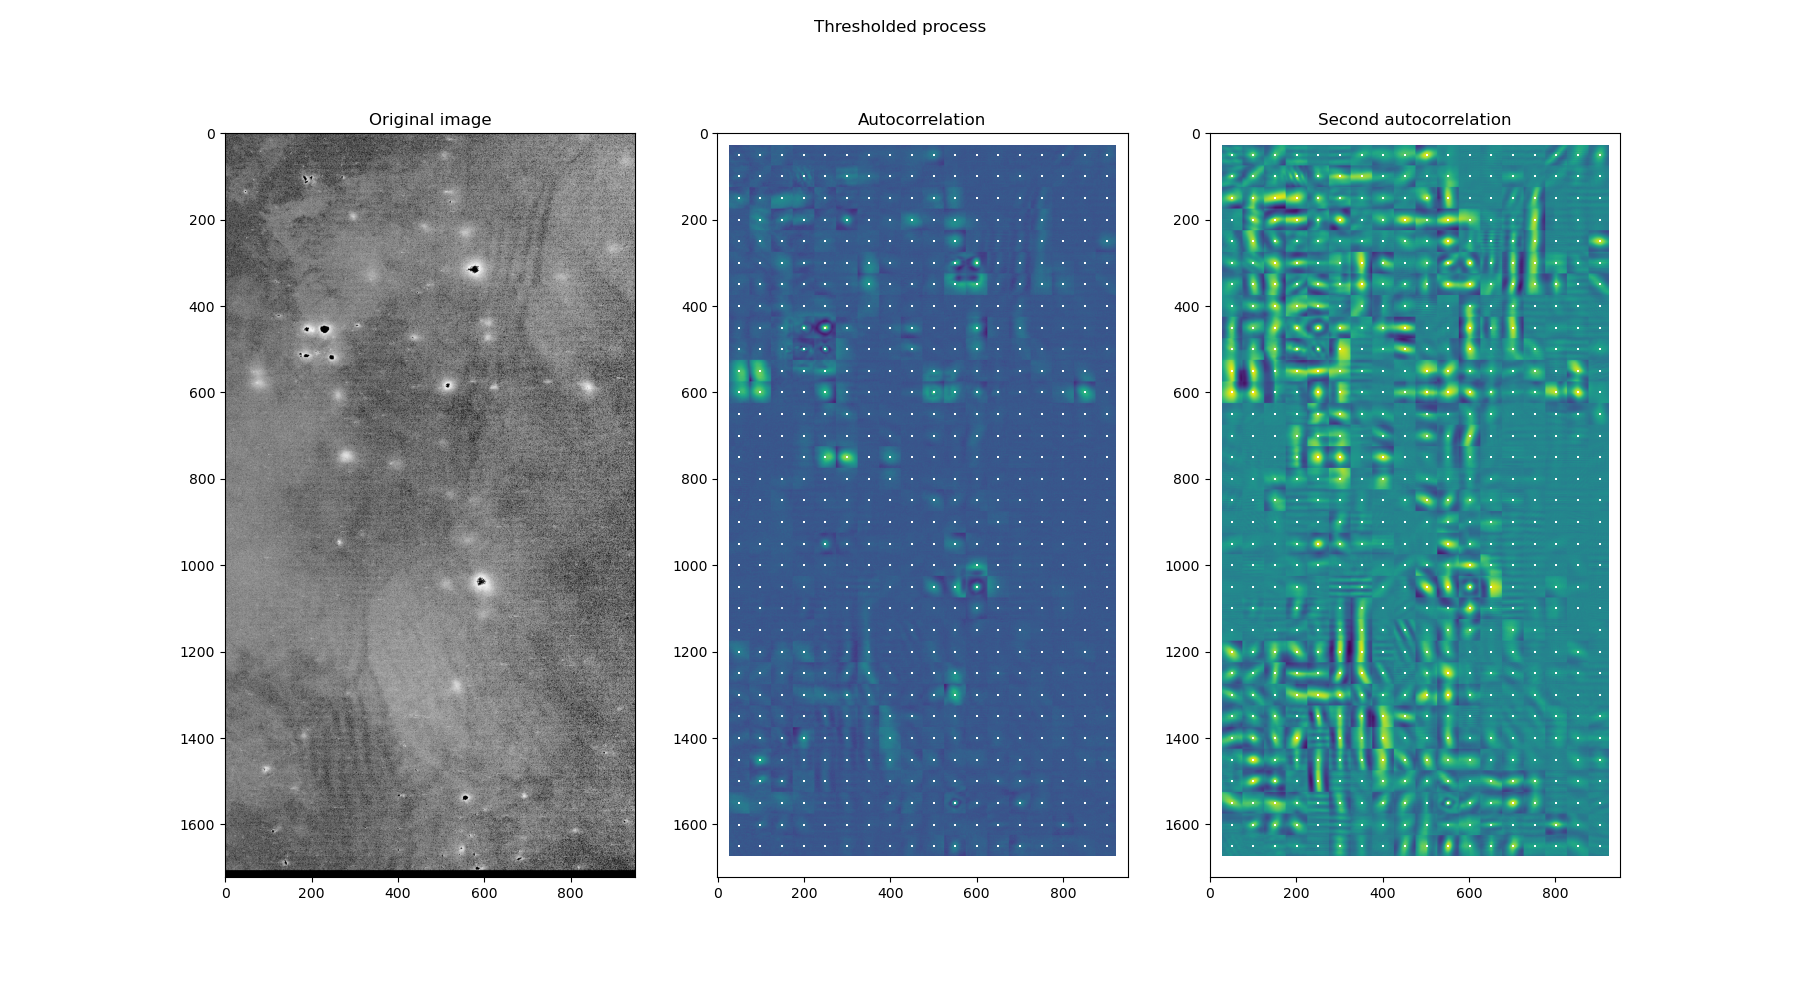

In [176]:
F, ax = plt.subplots(1, 3, figsize=(18, 10))
ax[0].imshow(img_array_thresh, cmap='gray', clim=(0, 255))
ax[0].set_title('Original image')
ax[1].imshow(corr_im_thresh)
ax[1].set_title('Autocorrelation')
ax[2].imshow(corr_im_thresh_2)
ax[2].set_title('Second autocorrelation')
F.suptitle('Thresholded process');

## Synthetic image to test autocorrelation

In [18]:
x = np.linspace(0, 60, 1000)
xdat = np.sin(x)
temp_im = np.stack([xdat]*1000)

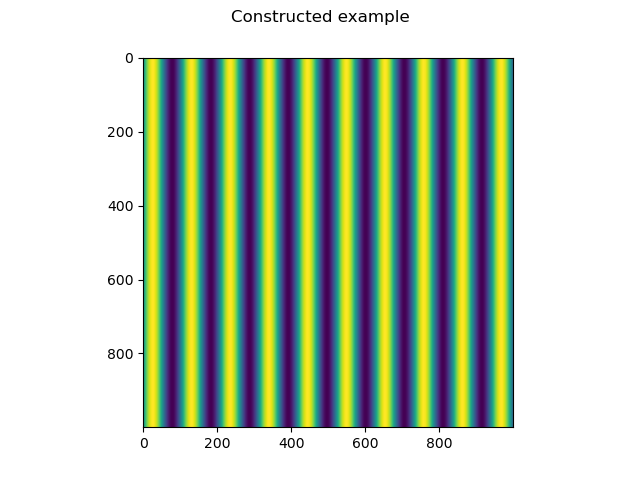

In [19]:
F, ax = plt.subplots()
F.suptitle("Constructed example")
ax.imshow(temp_im)

In [20]:
corr_im = auto_correlate(temp_im, 400, 400, 200, 200)

In [21]:
F, ax = plt.subplots()
F.suptitle("Autocorrelation of constructed example")
ax.imshow(corr_im)

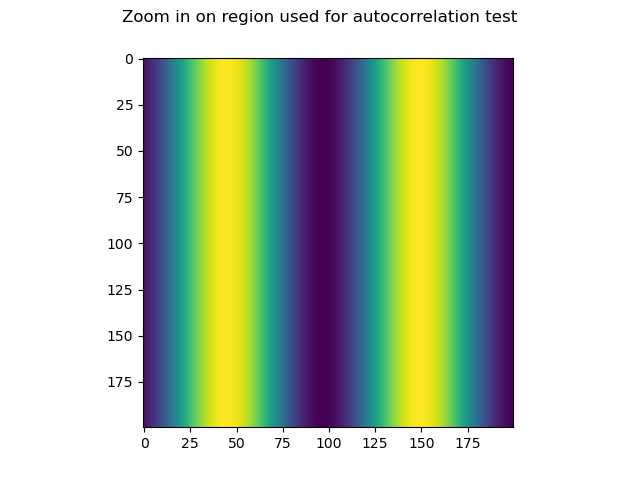

In [22]:
F, ax = plt.subplots()
F.suptitle("Zoom in on region used for autocorrelation test")
ax.imshow(temp_im[400:600, 400:600])

## Try Fourier-based autocorrelation

In [23]:
f_img_crop = scipy.fft.fft(img_crop)

In [24]:
power_spec = (np.abs(f_img_crop))**2

In [25]:
img_crop_corr = np.abs(scipy.fft.fft(power_spec))

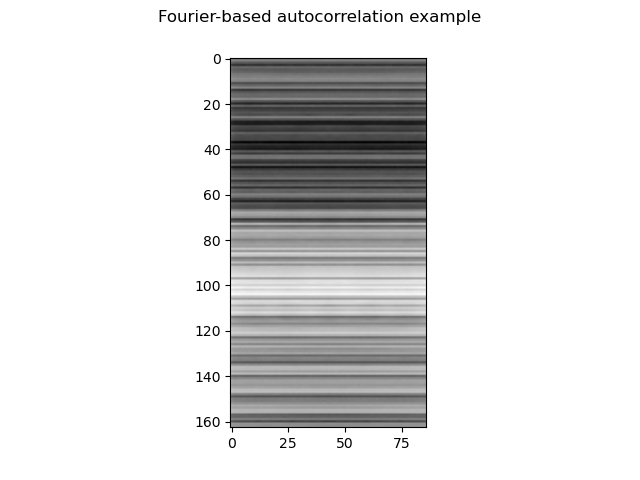

In [26]:
F, ax = plt.subplots()
F.suptitle("Fourier-based autocorrelation example")
ax.imshow(img_crop_corr, cmap='gray')